In [1]:
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr' 

from matplotlib import pyplot as plt
from matplotlib import rcParams
from astropy import units as u
import numpy as np

import yssbtmpy_ana2021 as tm
from accutil import linticker
from pathlib import Path
FIGDIR = Path('figs')

In [2]:
# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
rcParams.update({'font.size':12})

## 1. Reproducing Fig 5 of RavajiB+2019
In this section, I will reproduce the (nearly) identical figure as in RavajiB+19 (Fig. 5 of theirs). 

In [3]:
_prots = np.logspace(-2, 4, 50)*u.h
_rhs = np.arange(0.0, 2.5, 0.05)*u.au + 0.05*u.au
_rr, _pp = np.meshgrid(_rhs, _prots)

_ti = 1800
_alb_bond = 0.10
_hr = 1*u.h

nlon = 360*1

_shape = (_prots.size, _rhs.size)

_temp_maxs = np.zeros(_shape)
_dtemp_maxs = np.zeros(_shape)
_dtempdt_maxs = np.zeros(_shape)
_thetapars = np.zeros(_shape)

for i_p, prot in enumerate(_prots):
    print(i_p, end=' ')
    for i_r, r_hel in enumerate(_rhs):
        t_eqm = tm.T_eqm(a_bond=_alb_bond, emissivity=0.90, r_hel=r_hel, return_quantity=False)
        th = tm.Thetapar(ti=_ti, emissivity=0.90, temp_eqm=t_eqm, rot_period=prot)
        sb = tm.SmallBody()
        sb.minimal_set(th, 90)
        sb.set_tpm(nlat=3, nlon=nlon)
        sb.calc_temp()
        temps = sb.tempsurf[1, :]
        dt_minute = prot.to_value(u.min)/nlon
        _thetapars[i_p, i_r] = th
        _temp_maxs[i_p, i_r] = t_eqm*temps.max()
        _dtemp_maxs[i_p, i_r] = t_eqm*(temps.max() - temps.min())
        _dtempdt_maxs[i_p, i_r] = t_eqm*np.max(np.abs(np.ediff1d(temps)/dt_minute))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

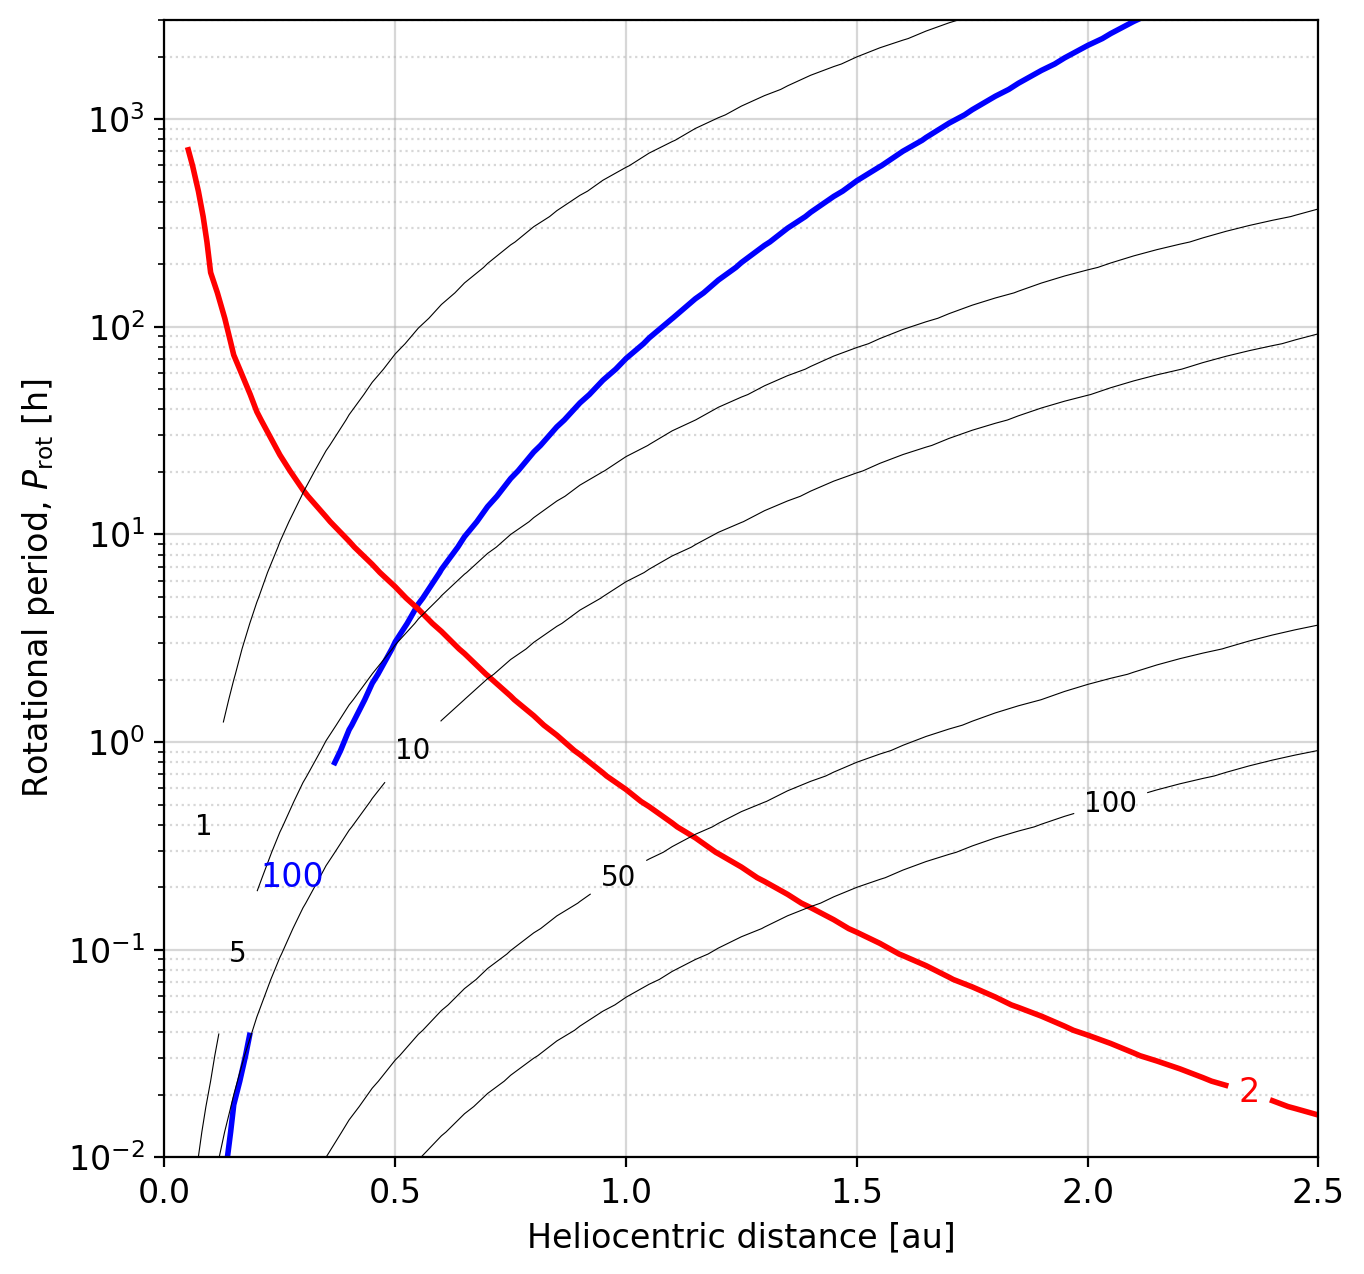

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(7, 6.5), 
                        sharex=False, sharey=False, gridspec_kw=None)

ax = axs
cs_tmax = ax.contour(_rr, _pp, _dtemp_maxs, levels=(100,), colors='b', linewidths=2)
cs_tmax.clabel(fmt="%.0f")
cs_dtdt = ax.contour(_rr, _pp, _dtempdt_maxs, levels=(2,), colors='r', linewidths=2)
cs_dtdt.clabel(fmt="%.0f")
cs_theta = ax.contour(_rr, _pp, _thetapars, levels=(1, 5, 10, 50, 100), colors='k', linewidths=0.4)
cs_theta.clabel(fmt="%.0f", fontsize=10)

ax.set(
    xlim=(0, 2.5),
    ylim=(1.e-2, 3.e+3),
    xscale='linear',
    yscale='log',
    xlabel="Heliocentric distance [au]",
    ylabel="Rotational period, $P_\mathrm{rot}$ [h]",
    title=""
)

plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)
linticker(axs)
plt.show();

# plt.savefig(figoutpath, dpi=300, bbox_inches = "tight")

## 2. Plotting More General Figure
Now I want to use $\Theta$ in the y-axis than $P_\mathrm{rot}$. This is the one presented in our work (Bach & Ishiguro). Note
$$ T_\mathrm{eqm} =  
    T_1 \left ( \frac{1-A_B}{\bar{\epsilon}_S } \right )^{1/4}
    \left ( \frac{r_\mathrm{h}}{1\,\mathrm{au}} \right )^{-1/2}
    = c_T \times T_1 \left ( \frac{r_\mathrm{h}}{1\,\mathrm{au}} \right )^{-1/2}
$$
with $ T_1 := \left ( \frac{L_\odot}{4\pi (1\,\mathrm{au})^2 \sigma_\mathrm{SB}} \right )^{1/4} = 394.0 \,\mathrm{K}$ is a universal constant and $ c_T := \left ( \frac{1-A_B}{\bar{\epsilon}_S } \right )^{1/4}$.

$$ \Theta
    = \frac{\Gamma}{T_\mathrm{eqm}^3 \sigma_\mathrm{SB} \bar{\epsilon}_S }
      \sqrt{\frac{2\pi}{P_\mathrm{rot}}} 
    \propto \Gamma P_\mathrm{rot}^{-1/2}  ~.
$$


In [5]:
thetas = np.logspace(-2, +2, 50)
temp_maxs = np.zeros((thetas.size))
dtemp_maxs = np.zeros((thetas.size))
dtempdt_maxs = np.zeros((thetas.size))
nlon = 360*5  # P_rot / time(lontidue)-bin == nlon

for i, th in enumerate(thetas):
    sb = tm.SmallBody()
    sb.minimal_set(th, 90, temp_eqm=1)
    sb.set_tpm(nlat=3, nlon=nlon)
    sb.calc_temp()
    temps = sb.tempsurf[1, :]
    temp_maxs[i] = temps.max()
    dtemp_maxs[i] = temps.max() - temps.min()  # Δ\hat{T}_s / T_eq in RavajiB+2019JGRE
    dtempdt_maxs[i] = np.max(np.abs(np.ediff1d(temps)))  # d\hat{T}_s/dt in RavajiB+2019JGRE [per minute]

r_hs = np.arange(0.05, 1.1, 0.01)
t_eqms = tm.T_eqm(a_bond=0, emissivity=1, r_hel=r_hs, return_quantity=False)

phaethon_thetas = np.zeros((r_hs.size))
phaethon_thetas_rh = np.zeros((r_hs.size))
fiducial_thetas = np.zeros((r_hs.size))
fiducial_thetas_rh = np.zeros((r_hs.size))

for i, r_hel in enumerate(r_hs):
    t_eqm = tm.T_eqm(a_bond=0.05, emissivity=0.9, r_hel=r_hel, return_quantity=False)
    fiducial_thetas[i] = tm.Thetapar(ti=200, temp_eqm=t_eqm, rot_period=6*u.h, emissivity=0.9)
    fiducial_thetas_rh[i] = tm.Thetapar(ti=200*r_hel**-0.75, temp_eqm=t_eqm, rot_period=6*u.h, emissivity=0.9)
    t_eqm = tm.T_eqm(a_bond=0.046, emissivity=0.9, r_hel=r_hel, return_quantity=False)
    phaethon_thetas[i] = tm.Thetapar(ti=600, temp_eqm=t_eqm, rot_period=3.604*u.h, emissivity=0.9)
    phaethon_thetas_rh[i] = tm.Thetapar(ti=600*r_hel**-0.75, temp_eqm=t_eqm, rot_period=3.604*u.h, emissivity=0.9)
    

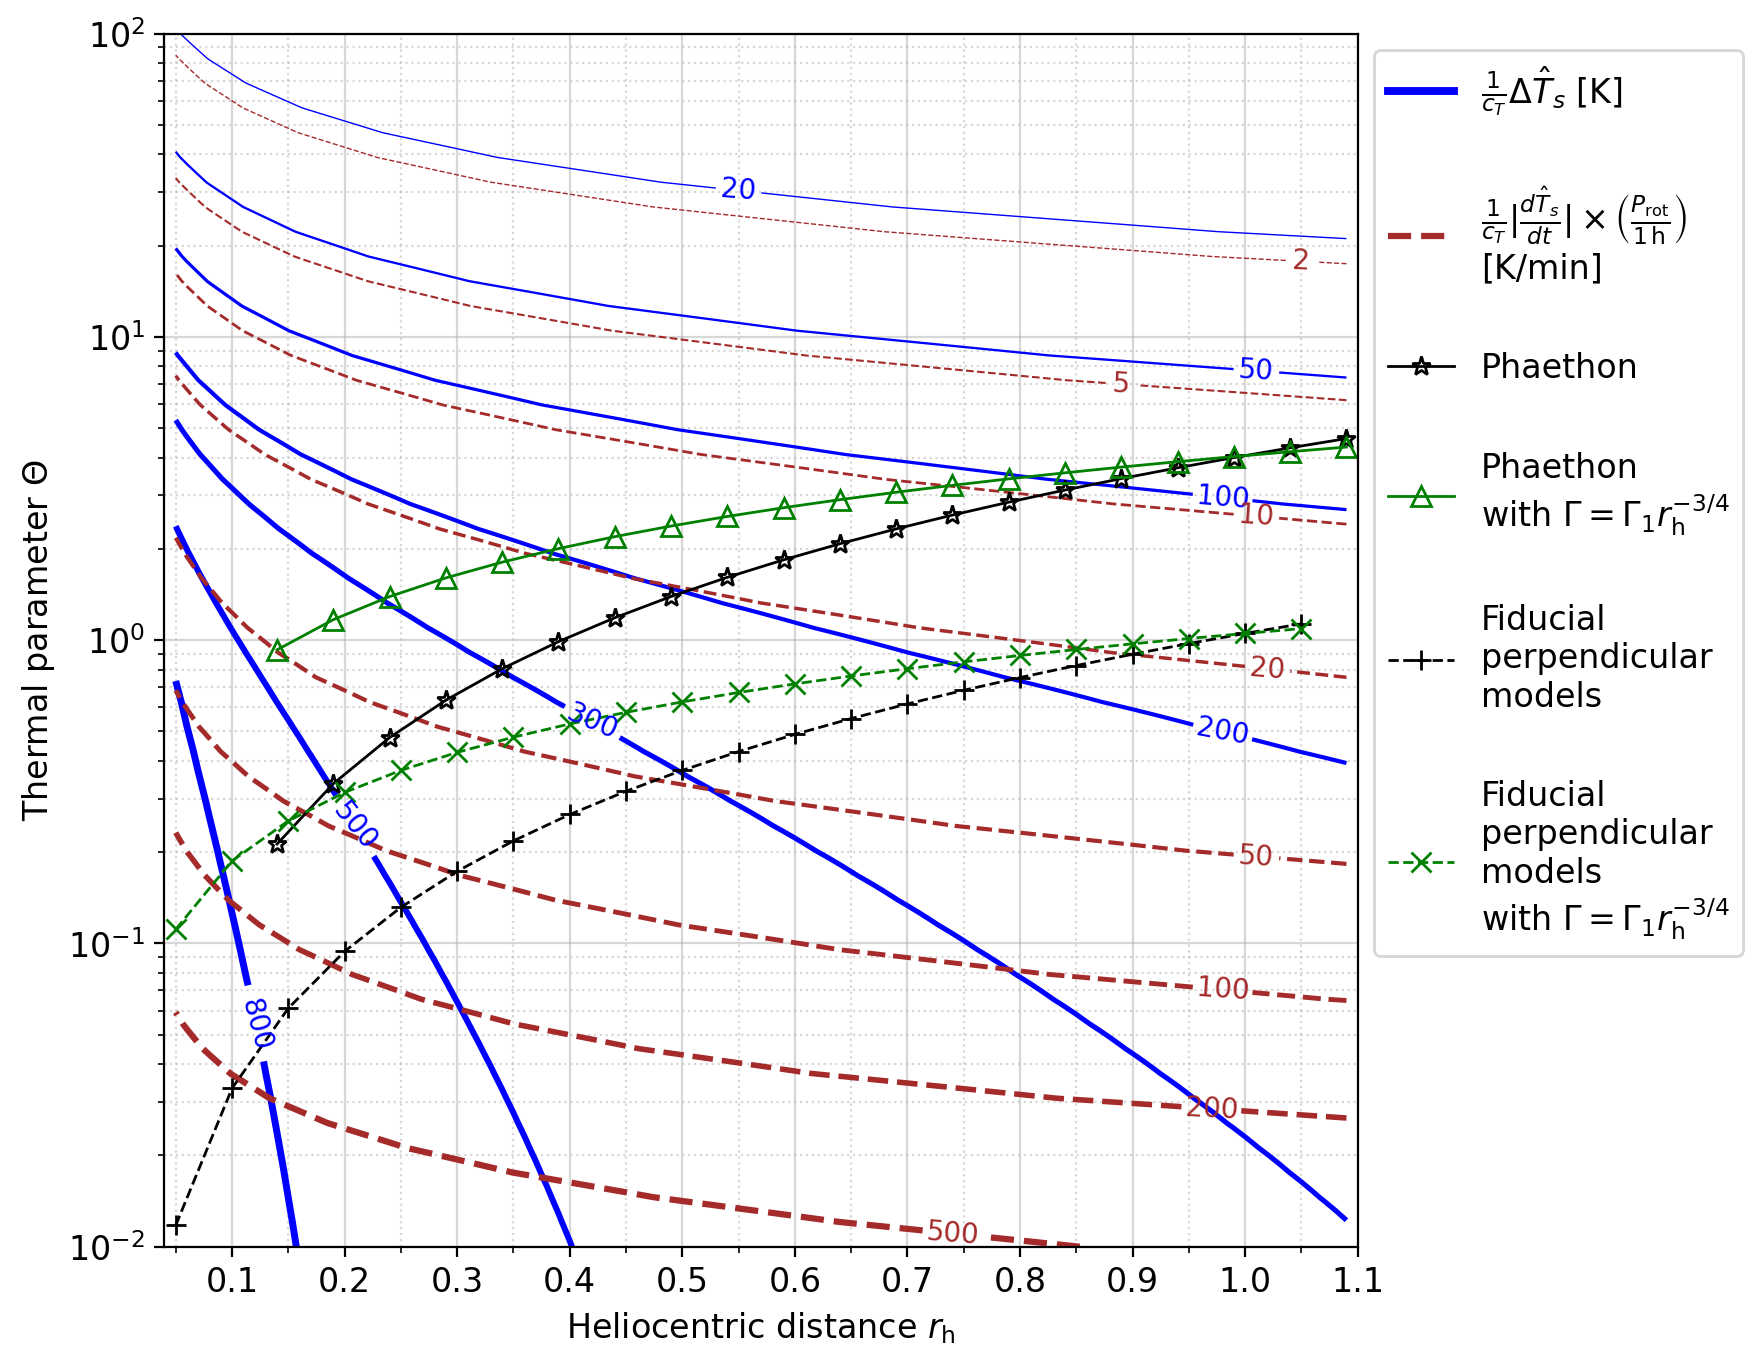

<Figure size 640x480 with 0 Axes>

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(9, 7), 
                        sharex=False, sharey=False, gridspec_kw=None)

ax = axs
# ax.plot(thetas, temp_maxs*t_eqms)
# ax.plot(thetas, dtdt_maxs)
# cs_tmax = ax.contourf(
#     r_hs, thetas, np.outer(dtemp_maxs, t_eqms), 
#     alpha=0.2, cmap='b', levels=lv_dtmax
# )

kw_dtmax = dict(c='b', ls='-', 
                lw=np.arange(8)/3 + 0.5, 
                levels=(20, 50, 100, 200, 300, 500, 800))
kw_dtemp = dict(c='brown', ls='--', 
                lw=np.arange(8)/4 + 0.5, 
                levels=(2, 5, 10, 20, 50, 100, 200, 500))

data2plot = [
    np.outer(dtemp_maxs, t_eqms),  # \Delta \hat{T}_s 
    np.outer(dtempdt_maxs/(60/nlon), t_eqms)  # d\hat{T}_s/dt
]
names = [
    r"$\frac{1}{c_T} \Delta \hat{T}_s$ [K]",
    (r"$\frac{1}{c_T} \left\|\frac{d\hat{T}_s}{dt} \right \|"
     + r"\times \left ( \frac{P_\mathrm{rot}}{1\,\mathrm{h}} \right ) $"
     + "\n[K/min]")
]

ax.set(
    xlim=(0.04, 1.1),
    ylim=(1.e-2, 1.e+2),
    xscale='linear',
    yscale='log',
    xlabel=r"Heliocentric distance $r_\mathrm{h}$",
    ylabel=r"Thermal parameter $\Theta$",
    title=""
)

for data, kw, name in zip(data2plot, [kw_dtmax, kw_dtemp], names):
    cs = ax.contour(
        r_hs, thetas, data, levels=kw['levels'], 
        colors=kw['c'], linestyles=kw['ls'], linewidths=kw['lw']
    )
    ax.plot(np.nan, np.nan, color=kw['c'], ls=kw['ls'], lw=kw['lw'][-1], label=name)
    cs.clabel(fmt=r'%.f', fontsize=10)


# ax.plot(0.14, 0.21, '*', ms=20, color='r', label="(3200) Phaethon")
lwms = dict(lw=1, ms=7, mfc='none')

ax.plot(r_hs[9::5], phaethon_thetas[9::5], 'k*-', **lwms, 
        label="Phaethon")
ax.plot(r_hs[9::5], phaethon_thetas_rh[9::5], 'g^-', **lwms, 
        label="Phaethon\n"+ r"with $\Gamma = \Gamma_1 r_\mathrm{h}^{-3/4}$")
ax.plot(r_hs[::5], fiducial_thetas[::5], 'k+--', **lwms,
        label="Fiducial\nperpendicular\nmodels")
ax.plot(r_hs[::5], fiducial_thetas_rh[::5], 'gx--', **lwms, 
        label="Fiducial\nperpendicular\nmodels\n" + r"with $\Gamma = \Gamma_1 r_\mathrm{h}^{-3/4}$")
# ax.legend(bbox_to_anchor=(1, -0.15), ncol=1)
ax.legend(bbox_to_anchor=(1, 1), ncol=1, labelspacing=2)



linticker(axs, xmajlockws=0.1, xminlockws=0.05)

plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)
plt.show();

plt.savefig(FIGDIR/"Theta-rh.pdf", dpi=300, bbox_inches = "tight");
plt.savefig(FIGDIR/"Theta-rh.png", dpi=300, bbox_inches = "tight");